# Annual modulation of DM-electron scattering
Want to do a cross check of the result of Lee et al. on the fourier coefficients for annual modulation. These are defined by expressing the rate as,

\begin{equation}
\frac{dR}{dE_R} = A_0 + \sum_{i = 1}^{\infty} A_n \cos{n\omega(t-t_n)}\
\end{equation}

Initially I was unable to reproduce Fig. 6 from https://arxiv.org/abs/1508.07361 but then I realised they do a slightly strange thing and plot the fourier coefficients $A_1/A_0$ and $A_2/A_0$ as a function of $E_d$ which is defined as $E_d = E_R + E_B$. This is the energy deposited in a semiconductor but is not the energy of the recoiling electron. So when they plot values of $E_d$ for xenon going down to 1 eV, this corresponds to negative values of $E_R$? (Since $E_B > 12.4$ eV) 

### First lets look at $g(v_{\rm min})$
Calculate for the SHM rather than SHM++ here for a straightforward comparison (the Sausage messes up the higher order modes a bit)

In [112]:
import sys
sys.path.append('../erec')
from numpy import *
import matplotlib.pyplot as plt
from LabFuncs import *
from Params import *
from DMFuncs import *
from PlotFuncs import *
from HaloFuncs import *
from Params import *
from AtomicFuncs import *

# v_mins
n = 1000
vmin_fine = linspace(0.01,800.0,n)

# Times
ndays = 100
days = linspace(0.0,365.0-365.0/ndays,ndays)

# Calculate gmin
sig_iso = SHM.Dispersion*array([1,1,1])
gmin_fine = zeros(shape=(ndays,n))
gmin_fine_gf = zeros(shape=(ndays,n))
for i in range(0,ndays):
    gmin_fine[i,:] = gvmin_Isotropic(vmin_fine,day=days[i],sig=SHM.Dispersion,v_esc=SHM.EscapeSpeed,v_LSR=SHM.RotationSpeed)
    gmin_fine_gf[i,:] = gvmin_Triaxial(vmin_fine,day=days[i],sig=sig_iso,GravFocus=True,v_esc=SHM.EscapeSpeed,v_LSR=SHM.RotationSpeed)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


### And calculate the fourier coefficients:

/Users/ciaranohare/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/Users/ciaranohare/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/ciaranohare/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/Users/ciaranohare/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


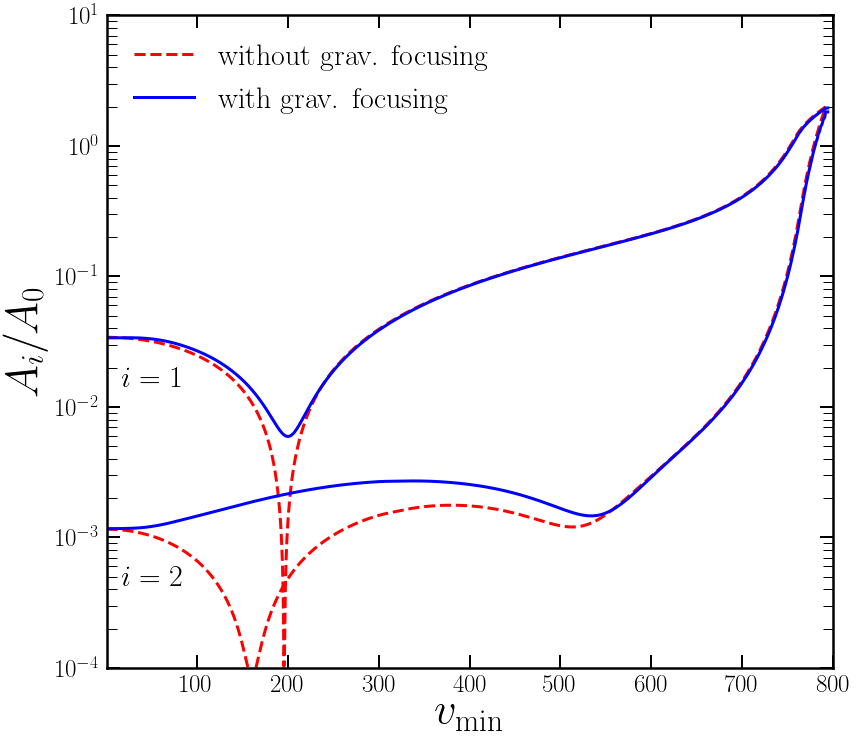

In [114]:
from numpy.fft import fft

# Function to get nc fourier components
def FourierComponents(gmin,nc):
    nv = shape(gmin)[1]
    nt = shape(gmin)[0]
    a0 = zeros(shape=nv)
    b = zeros(shape=(nc,nv))
    a = zeros(shape=(nc,nv))
    for i in range(0,nv):
        y = gmin[:,i]
        yfft = fft(y)/(1.0*nt)
        yfft = yfft[0:(nc+1)]
        a0[i] = real(yfft[0])
        a[:,i] = 2*real(yfft[1:])
        b[:,i] = -2*imag(yfft[1:])
    return a0,a,b


fig,ax1 = MySquarePlot(r"$v_{\rm min}$",r'$A_i/A_0$')

A0,a_1,b_1 = FourierComponents(gmin_fine,5) 
A1 = sqrt(a_1[0,:]**2.0+b_1[0,:]**2.0)
A2 = sqrt(a_1[1,:]**2.0+b_1[1,:]**2.0)
plt.plot(vmin_fine,A1/A0,'r--',lw=3)
plt.plot(vmin_fine,A2/A0,'r--',lw=3,label='without grav. focusing')

A0,a_1,b_1 = FourierComponents(gmin_fine_gf,5) 
A1 = sqrt(a_1[0,:]**2.0+b_1[0,:]**2.0)
A2 = sqrt(a_1[1,:]**2.0+b_1[1,:]**2.0)
plt.plot(vmin_fine,A1/A0,'b-',lw=3)
plt.plot(vmin_fine,A2/A0,'b-',lw=3,label='with grav. focusing')

plt.legend(frameon=False,fontsize=30)

plt.yscale('log')
plt.xlim([1,800])
plt.ylim([1e-4,1e1])
plt.gcf().text(0.14,0.45,r'$i=1$',fontsize=30,rotation=0)
plt.gcf().text(0.14,0.22,r'$i=2$',fontsize=30,rotation=0)

plt.show()

## So notably we have the phase flip at $v_{\rm min} \simeq 200$ km/s. The gravitational focusing softens the transition somewhat so we don't have a sharp flip in the phase but rather it changes smoothly from Dec to Jun

## Now let's look at the fourier coefficients for the DM-rate
We'll define a new function here rather than the main one in `erec/DMFuncs.py` because we'll need to modify it as we'll see in a second

In [115]:
E_r_vals = logspace(-1.0,3.0,500)/1000.0
sigma_e = 1.0e-37
rho_0 = 0.55
Atom = Xe131
nq = 20
DMFormFactor = HeavyMediator

# modifiying this so we can play with the binding energies E_B
def ElectronRecoilRate_modified(E_B_vals,m_DM):
    
    nsh = size(E_B_vals)
    Efine,qfine,fion_fine = Atom.IonisationFormFactor()

    # Constants
    m_DM_keV = m_DM*1000 # keV
    ne = size(E_r_vals)
    m_N_kg = Atom.MassNumber*m_p_kg # keV
    N_T = 1.0/m_N_kg # kg
    mu = m_DM_keV*m_e/(m_e+m_DM_keV) # keV
    n_DM = rho_0*1e6/m_DM_keV # cm**-3.0
    vmax = ((850.0)*1000)/3.0e8 # natural units
    
    dRdlnE = zeros(shape=(ndays,ne))
    for it in range(0,ndays):
        for sh in range(0,nsh): # over orbitals
            E_B = E_B_vals[sh]
            Emax = 0.5*m_DM_keV*vmax**2.0
            if Emax>E_r_vals[0]:
                imax = arange(0,ne)[E_r_vals<Emax][-1]
                for i in range(0,imax+1): # over energies
                    E_r = E_r_vals[i]
                    if E_r<(0.5*m_DM_keV*vmax**2.0-E_B):

                        # Form factor
                        qmax = m_DM_keV*vmax*(1.0+sqrt(1-2*(E_r+E_B)/(m_DM_keV*vmax**2.0)))
                        qmin = m_DM_keV*vmax*(1.0-sqrt(1-2*(E_r+E_B)/(m_DM_keV*vmax**2.0)))
                        qvals = logspace(log10(qmin),log10(qmax),nq)
                        fion = interp(qvals,qfine,fion_fine[argmin(abs(Efine-E_r)),:,sh])

                        # interpolate at required vmin and calculate cross section
                        vmin_vals = vmin_ER(E_B,E_r,qvals,m_DM)
                        gmin = interp(vmin_vals,vmin_fine,gmin_fine_gf[it,:])/(1000*100)
                        qfunc = qvals*fion*gmin*DMFormFactor(qvals)
                        dsigma = (100*3.0e8)**2*(sigma_e/(8*mu**2.0))*trapz(qfunc,qvals) # cm^2

                        # rate
                        dRdlnE[it,i] += N_T*n_DM*\
                                AtomicFuncs.FermiFactor(E_r)*dsigma # kg^-1 s^-1
    dRdlnE *= (365*3600*24) # kg^-1 yr^-1
    return dRdlnE

### Now fix the binding energies (to what they should be) and plot the $A_1$ and $A_2$ for two masses

/Users/ciaranohare/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/Users/ciaranohare/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/Users/ciaranohare/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/Users/ciaranohare/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


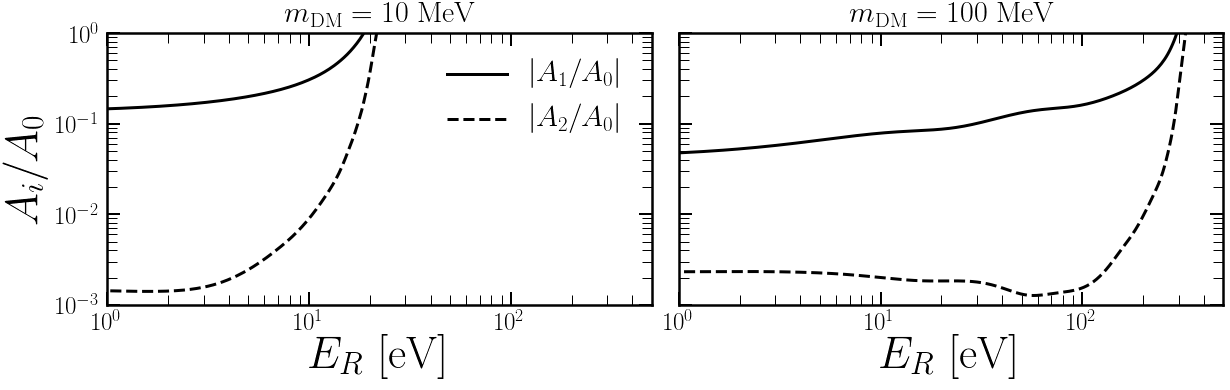

In [116]:
# xenon binding energies
E_B_vals = array([12,26,76])/1000.0

R1 = ElectronRecoilRate_modified(E_B_vals,10.0)
R2 = ElectronRecoilRate_modified(E_B_vals,100.0)

fig,ax1,ax2 = MyDoublePlot(r"$E_R$ [eV]",r'$A_i/A_0$',r"$E_R$ [eV]",wspace=0.05,size_y=5)


A0,a_1,b_1 = FourierComponents(R1,5) 
A1 = sqrt(a_1[0,:]**2.0+b_1[0,:]**2.0)
A2 = sqrt(a_1[1,:]**2.0+b_1[1,:]**2.0)
ax1.plot(E_r_vals*1000,abs(A1/A0),'k-',lw=3,label=r'$|A_1/A_0|$')
ax1.plot(E_r_vals*1000,abs(A2/A0),'k--',lw=3,label=r'$|A_2/A_0|$')
ax1.legend(frameon=False,fontsize=30)

A0,a_1,b_1 = FourierComponents(R2,5) 
A1 = sqrt(a_1[0,:]**2.0+b_1[0,:]**2.0)
A2 = sqrt(a_1[1,:]**2.0+b_1[1,:]**2.0)
ax2.plot(E_r_vals*1000,abs(A1/A0),'k-',lw=3)
ax2.plot(E_r_vals*1000,abs(A2/A0),'k--',lw=3)

ax1.set_yscale('log')
ax2.set_yscale('log')
ax1.set_xscale('log')
ax2.set_xscale('log')
ax1.set_xlim([1,500])
ax2.set_xlim([1,500])
ax1.set_ylim([1e-3,1])
ax2.set_ylim([1e-3,1])
ax2.set_yticklabels([])

ax1.set_title(r'$m_{\rm DM} = 10$ MeV',fontsize=30)
ax2.set_title(r'$m_{\rm DM} = 100$ MeV',fontsize=30)

plt.show()

### This clearly is notably different from Fig. 6 of Lee et al. Although the tails of these curves seem to more or less agree.

### Now we try again but do as they do and plot vs $E_d = E_R + E_B$. This requires us to set $E_B$ to zero so that we have control over $E_d$ going down below the binding energies of the xenon electrons

/Users/ciaranohare/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/Users/ciaranohare/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/Users/ciaranohare/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/Users/ciaranohare/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


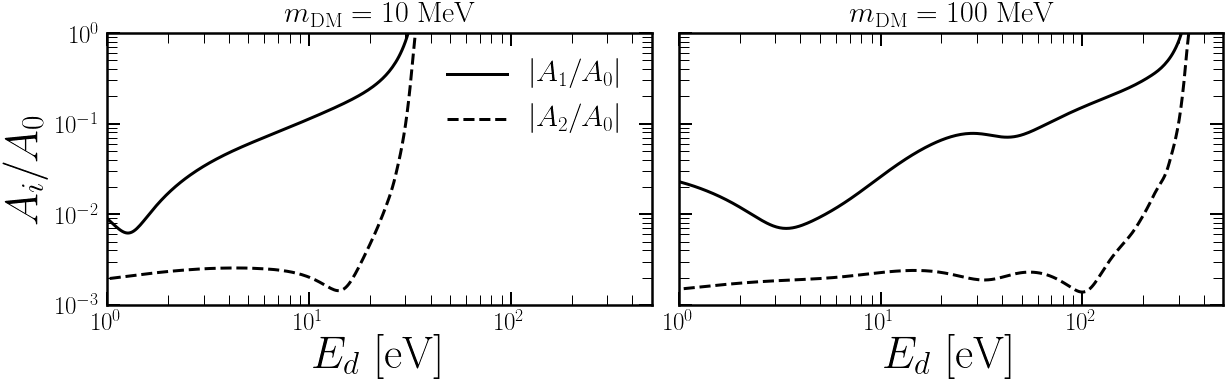

In [117]:
# xenon binding energies
E_B_vals = array([0.0,0.0,0.0])

R1 = ElectronRecoilRate_modified(E_B_vals,10.0)
R2 = ElectronRecoilRate_modified(E_B_vals,100.0)

fig,ax1,ax2 = MyDoublePlot(r"$E_d$ [eV]",r'$A_i/A_0$',r"$E_d$ [eV]",wspace=0.05,size_y=5)


A0,a_1,b_1 = FourierComponents(R1,5) 
A1 = sqrt(a_1[0,:]**2.0+b_1[0,:]**2.0)
A2 = sqrt(a_1[1,:]**2.0+b_1[1,:]**2.0)
ax1.plot(E_r_vals*1000,abs(A1/A0),'k-',lw=3,label=r'$|A_1/A_0|$')
ax1.plot(E_r_vals*1000,abs(A2/A0),'k--',lw=3,label=r'$|A_2/A_0|$')
ax1.legend(frameon=False,fontsize=30)

A0,a_1,b_1 = FourierComponents(R2,5) 
A1 = sqrt(a_1[0,:]**2.0+b_1[0,:]**2.0)
A2 = sqrt(a_1[1,:]**2.0+b_1[1,:]**2.0)
ax2.plot(E_r_vals*1000,abs(A1/A0),'k-',lw=3)
ax2.plot(E_r_vals*1000,abs(A2/A0),'k--',lw=3)

ax1.set_yscale('log')
ax2.set_yscale('log')
ax1.set_xscale('log')
ax2.set_xscale('log')
ax1.set_xlim([1,500])
ax2.set_xlim([1,500])
ax1.set_ylim([1e-3,1])
ax2.set_ylim([1e-3,1])
ax2.set_yticklabels([])

ax1.set_title(r'$m_{\rm DM} = 10$ MeV',fontsize=30)
ax2.set_title(r'$m_{\rm DM} = 100$ MeV',fontsize=30)

plt.show()

### Which is essentially what they get. It's still not perfect agreement which I would guess comes down to $|f_{\rm ion}(q)|^2$ since their form factor for xenon 5p still doesn't quite match mine. 

# The final point is that I think in a xenon experiment the phase flip will never appear because $E_B$ is always too high
I think the energies plotted in Lee et al. are not physical? Unless one is talking about a semiconductor experiment. In a germanium experiment the binding energy is low so the $v_{\rm min}(E_R,q)$ function extends much deeper into $g(v_{\rm min})$ so will be able to pick up the region before the phase flip.

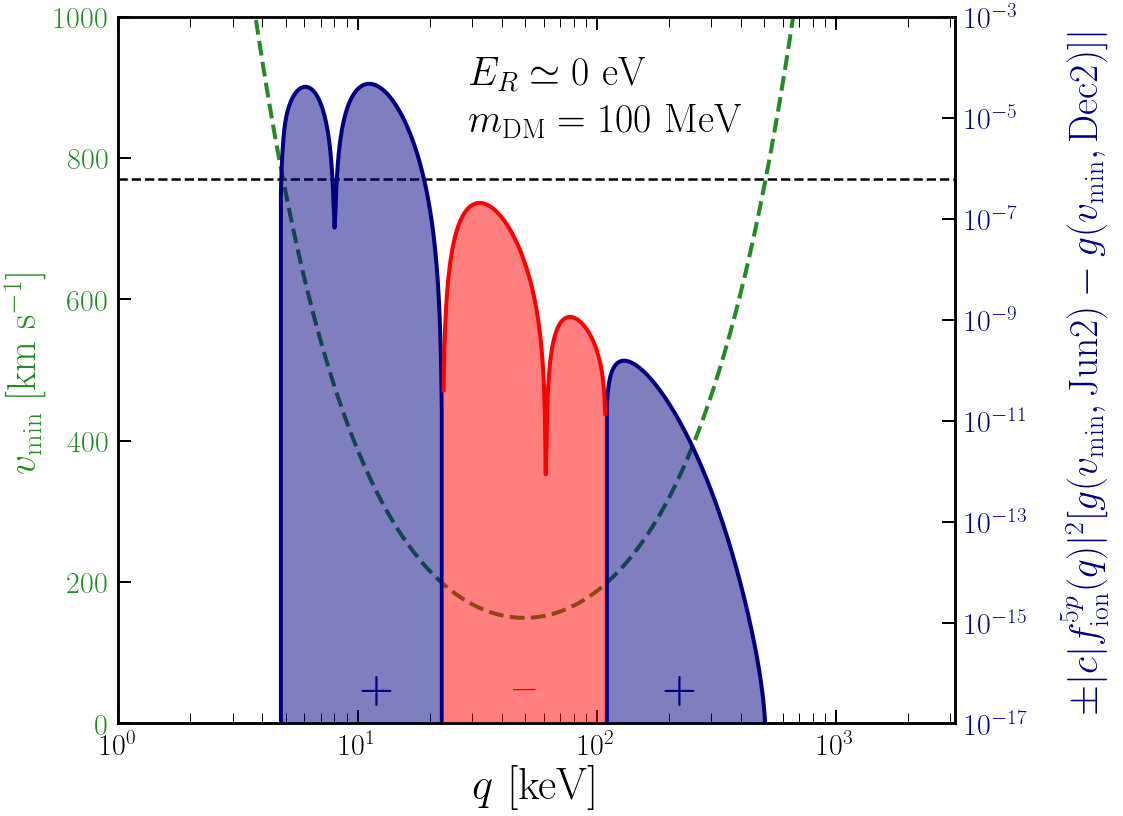

In [121]:
# p orbitals
n_p = array([2]*2+[3]*3+[4]*3+[5]*4)
Z_p = array([58.7712,22.6065,48.9702,13.4997,9.8328,40.2591,7.1841,5.1284,21.5330,3.4469,2.2384,1.14588])
c_5p = array([-0.005879,0.149040,-0.018716,-0.266839,-0.031096,-0.024100,0.267374,0.161460,0.059721,-0.428353,-0.542284,-0.201667])

n = 1000

E_r = 0.01/1000.0
q_vals = logspace(0.0,3.5,n)

Jun2 = argmin(abs(days-152.0))
Dec2 = argmin(abs(days-336.0))


np = 100
F1 = f_nl_ion_sq(q_vals,E_r,1,c_5p,n_p,Z_p,np=np)
vmin_vals = vmin_ER(12.4/1000.0,E_r,q_vals,100.0)
gmin1 = interp(vmin_vals,vmin_fine,gmin_fine_gf[Jun2,:])*3e8/1000
gmin2 = interp(vmin_vals,vmin_fine,gmin_fine_gf[Dec2,:])*3e8/1000




plt.rcParams['axes.linewidth'] = 2.5
plt.rc('text', usetex=True)
plt.rc('font', family='serif',size=30)  
fig = plt.figure(figsize=(15,13))
ax1 = fig.add_subplot(111)


col1 = 'forestgreen'
col2 = 'navy'


ax1.semilogx(q_vals,vmin_vals,'--', color=col1,lw=4,zorder=100)

ax1.tick_params(which='both',axis='y', labelcolor=col1,width=2,length=13,right=True,top=True,direction='in',pad=10)
ax1.tick_params(axis='x',width=2,length=13,right=True,top=True,direction='in',pad=10)
ax1.set_ylim([0,1000])
ax1.plot([q_vals[0],q_vals[-1]],[770,770],'k--',lw=2.5)
ax1.set_xlim([q_vals[0],q_vals[-1]])

#dat = loadtxt('test.txt',delimiter=',')
#ax1.plot(dat[:,0],dat[:,1],'k-')


y2 = F1*(gmin1-gmin2)
ypos = abs(y2)[y2>0]
ypos[(ypos<1e-11)&(q_vals[y2>0]<200.0)] = 0.0
ypos[(ypos<1e-7)&(q_vals[y2>0]<7.0)] = 0.0

yneg = abs(y2)[y2<0]
#yneg[(yneg<1e-11)] = 0.0


ax2 = ax1.twinx()  
ax2.fill_between(q_vals[y2>0],ypos,color=col2,alpha=0.5)
ax2.loglog(q_vals[y2>0],ypos, color=col2,lw=4,zorder=-1)

ax2.fill_between(q_vals[y2<0],yneg,color='red',alpha=0.5)
ax2.loglog(q_vals[y2<0],yneg, color='red',lw=4)

ax2.tick_params(axis='y', labelcolor=col2,width=2,length=13,right=True,top=True,direction='in',pad=10)
ax2.set_ylim([1e-17,1e-3])

#dat = loadtxt('test2.txt',delimiter=',')
#ax1.plot(dat[:,0],dat[:,1],'k-')

#dat = loadtxt('test_chris.txt',delimiter=',')
#ax2.plot(dat[:,0],dat[:,1],'r-')



ax1.tick_params(which='minor',direction='in',width=1,length=10,right=True,top=True)
ax2.tick_params(which='minor',direction='in',width=1,length=10,right=True,top=True)
  
ax2.set_ylabel(r'$\pm\bigg|c |f^{5p}_{\rm ion}(q)|^2 \bigg[ g(v_{\rm min},{\rm Jun 2})-g(v_{\rm min},{\rm Dec 2})\bigg]\bigg|$', color=col2,fontsize=40,labelpad=40) 
ax1.set_xlabel(r'$q$ [keV]',fontsize=45)
ax1.set_ylabel(r'$v_{\rm min}$ [km s$^{-1}$]', color=col1,fontsize=40)

plt.gcf().text(0.45,0.8,r'$E_R\simeq 0$ eV',fontsize=40)
plt.gcf().text(0.45,0.75,r'$m_{\rm DM} = 100 $ MeV',fontsize=40)

plt.gcf().text(0.35,0.15,r'{\bf +}',fontsize=40,color='navy')
plt.gcf().text(0.49,0.16,r'{\bf --}',fontsize=40,color='red')
plt.gcf().text(0.63,0.15,r'{\bf +}',fontsize=40,color='navy')

plt.show()
pltname = 'vmin_vs_q_phaseflip'
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')